In [64]:
import os
import huggingface_hub as hf_hub

In [65]:
token = os.getenv("HUGGINGFACE_TOKEN")
hf_hub.login(token)

In [66]:
import re
import datetime
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search
from IPython.display import display, Markdown

In [67]:
runway = pd.read_csv("runway.csv", parse_dates=['review_date'])
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None


In [68]:
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.translate(string.punctuation)
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\d+", "")
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\s{2,}", "")
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.lower()
runway.head()

,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date,review_text_cleaned
0,476109,139086,8,formal affair,it hit the floor perfectly with a pair of heel...,gown,"5' 3""",15,27.0,2017-12-19,it hit the floor perfectly with a pair of heel...
1,203660,1126889,6,party,the dress is absolutely gorgeous unfortunately...,dress,"5' 4""",12,28.0,2022-01-03,the dress is absolutely gorgeous unfortunately...
2,868581,652189,8,wedding,even though it was lined with satin this was a...,dress,"5' 5""",24,30.0,2021-08-05,even though it was lined with satin this was a...
3,935076,1879504,8,wedding,this dress was greatit fit really well and was...,sheath,"5' 3""",14,37.0,2021-10-02,this dress was greatit fit really well and was...
4,995023,1179146,10,party,super flattering i am usually a sizemi have a ...,dress,"5' 2""",14,37.0,2022-11-20,super flattering i am usually a sizemi have a ...


In [69]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

sentiment_analysis = pipeline("sentiment-analysis", model=model)

sent_analysis_output = sentiment_analysis(list(runway['review_text_cleaned']))

Device set to use cpu


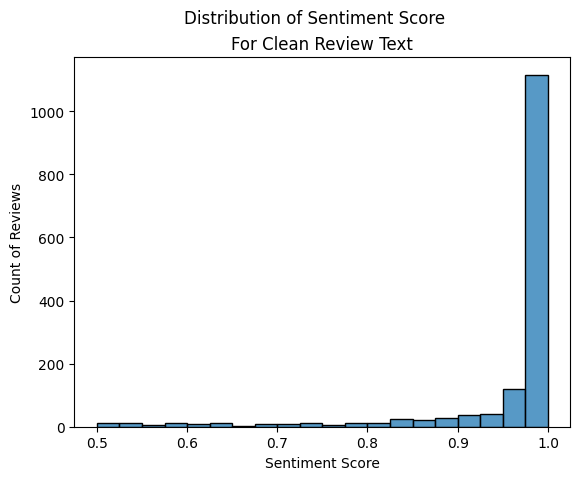

In [70]:
runway['clean_sentiment_category'] = [s['label'] for s in sent_analysis_output]
runway['clean_sentiment_score'] = [s['score'] for s in sent_analysis_output]

sns.histplot(data=runway, x='clean_sentiment_score', bins=20)
plt.suptitle("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count of Reviews")
plt.title("For Clean Review Text")
plt.show()

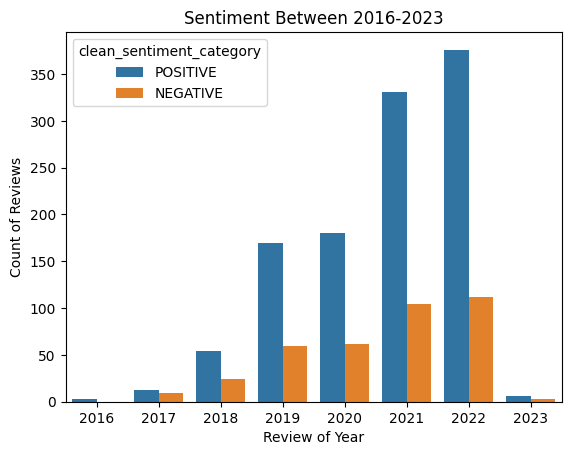

In [71]:
runway['year'] = runway['review_date'].dt.year

chart_data = runway.groupby(['year', 'clean_sentiment_category'], as_index=False)['user_id'].count()
chart_data.columns = ['year', 'clean_sentiment_category', 'cnt']

sns.barplot(data=chart_data, x='year', y='cnt', hue='clean_sentiment_category', errorbar=None)
plt.title("Sentiment Between 2016-2023")
plt.xlabel("Review of Year")
plt.ylabel("Count of Reviews")
plt.show()


In [72]:
sent_analysis_2 = sentiment_analysis(list(runway["review_text"]))

runway['sentiment_category'] = [s['label'] for s in sent_analysis_2]
runway['sentiment_score'] = [s['score'] for s in sent_analysis_2]

# Confusion Matrix??????
display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))

sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,373,1
POSITIVE,2,1130


In [73]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

model = SentenceTransformer(model_id)

embeddings = model.encode(list(runway['rented for']))

print(embeddings.shape)

(1506, 384)


In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)

tsne_dims = tsne.fit_transform(embeddings)
print(tsne_dims.shape)

(1506, 2)


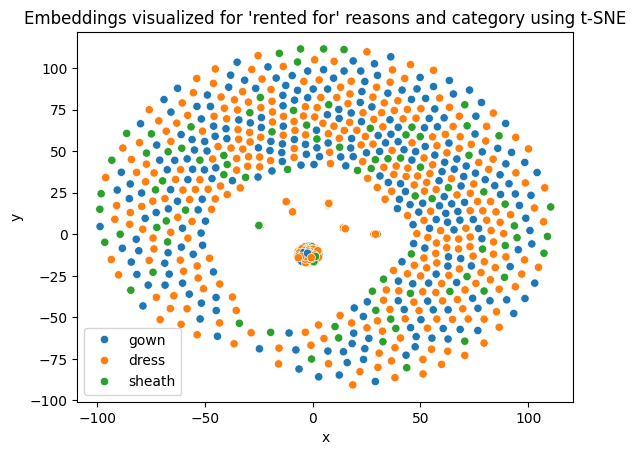

In [76]:
runway['x'] = [x for x, y in tsne_dims]
runway['y'] = [y for x, y in tsne_dims]

sns.scatterplot(x = "x", y = "y", hue = "category", data = runway)
plt.legend()
plt.title("Embeddings visualized for 'rented for' reasons and category using t-SNE")
plt.show()

In [77]:
query = "a gorgeous and flattering dress"

query_emb = model.encode(query, convert_to_tensor=True)

hits = semantic_search(query_emb, embeddings, top_k=3)

for hit in hits[0]:
    idx = hit['corpus_id']
    print(f"ITEM ID: {runway.iloc[idx]['item_id']}: RENTED FOR: {runway.iloc[idx]['rented for']}: REVIEW: {runway.iloc[idx]['review_text']}")

ITEM ID: 652189: RENTED FOR: wedding: REVIEW: even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID: 1498329: RENTED FOR: wedding: REVIEW: the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe colours are

In [81]:
generator = pipeline(model="gpt2")

prompt = "New for this winter season, a lovely dress that"

output = generator(prompt, num_return_sequences=1, return_full_text=False)

print("New Marketing Campaign: ", prompt, output[0]['generated_text'])

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign:  New for this winter season, a lovely dress that 's also made out of my hair and not long-tail, though these days my bra is still as loose as ever. After wearing my skirt for the first time my favorite look from season-four
